In [21]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

import gradio
from graph_utils import create_d3_visualization
from dotenv import load_dotenv
import os

In [3]:
load_dotenv()

True

In [4]:
# Access variables
openai_key = os.getenv('OPENAI_API_KEY')
arango_host = os.getenv('ARANGO_HOST')
arango_user = os.getenv('ARANGO_USER')
arango_password = os.getenv('ARANGO_PASSWORD')
arango_db = os.getenv('ARANGO_DB')


In [24]:
# Load nodes file - contains heroes and comics as two types of nodes
nodes_df = pd.read_csv('Data/marvel-bimodal-nodes.csv',
                       names=['ID', 'Label', 'type'],
                       header=0,
                       dtype={'ID': str, 'Label': str, 'type': str})

# Load edges file - contains connections between heroes and comics
edges_df = pd.read_csv('Data/marvel-bimodal-edges.csv',
                       names=['Source', 'Target'],
                       header=0)

# Display basic information about the bipartite graph data
print("\nNodes DataFrame Info (Heroes and Comics):")
print(nodes_df.info())
print("\nFirst few rows of nodes:")
print(nodes_df.head())

print("\nEdges DataFrame Info (Hero-Comic connections):")
print(edges_df.info())
print("\nFirst few rows of edges:")
print(edges_df.head())

# Basic bipartite network statistics
print(f"Total number of nodes: {len(nodes_df)}")
print(f"Total number of edges: {len(edges_df)}")
print("\nDistribution of node types (heroes vs comics):")
print(nodes_df['type'].value_counts())

# Verify bipartite structure by checking connections
hero_nodes_ids = nodes_df[nodes_df['type'] == 'hero']['ID']
comic_nodes_ids = nodes_df[nodes_df['type'] == 'comic']['ID']

# Check that edges only connect heroes to comics and identify failing nodes
invalid_sources = edges_df[~edges_df['Source'].isin(hero_nodes_ids)]['Source'].unique()
invalid_targets = edges_df[~edges_df['Target'].isin(comic_nodes_ids)]['Target'].unique()

heroes_as_source = edges_df['Source'].isin(hero_nodes_ids).all()
comics_as_target = edges_df['Target'].isin(comic_nodes_ids).all()

if len(invalid_sources) > 0:
    print("\nSource nodes that are not heroes:")
    print(invalid_sources)
    print("\nDetails of invalid source rows:")
    print(edges_df[edges_df['Source'].isin(invalid_sources)])
    
if len(invalid_targets) > 0:
    print("\nTarget nodes that are not comics:")
    print(invalid_targets)
    print("\nDetails of invalid target rows:")
    print(edges_df[edges_df['Target'].isin(invalid_targets)])

print("\nBipartite Structure Verification:")
print(f"All sources are heroes: {heroes_as_source}")
print(f"All targets are comics: {comics_as_target}")

print("\nNumber of unique heroes (sources):", edges_df['Source'].nunique())
print("Number of unique comics (targets):", edges_df['Target'].nunique())





Nodes DataFrame Info (Heroes and Comics):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19090 entries, 0 to 19089
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      19090 non-null  object
 1   Label   19090 non-null  object
 2   type    19090 non-null  object
dtypes: object(3)
memory usage: 447.5+ KB
None

First few rows of nodes:
                       ID                   Label   type
0                 2001 10                 2001 10  comic
1                  2001 8                  2001 8  comic
2                  2001 9                  2001 9  comic
3  24-HOUR MAN / EMMANUEL  24-HOUR MAN / EMMANUEL   hero
4  3-D MAN / CHARLES CHAN  3-D MAN / CHARLES CHAN   hero

Edges DataFrame Info (Hero-Comic connections):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96104 entries, 0 to 96103
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  96104 non-nul

In [25]:
# Select both ID and Label columns for heroes and comics
hero_nodes_df = nodes_df[nodes_df['type'] == 'hero']
comic_nodes_df = nodes_df[nodes_df['type'] == 'comic']


In [27]:

# Create NetworkX Graph
G = nx.Graph()

# Add hero nodes (partition 0) with attributes
G.add_nodes_from((row['ID'], {"bipartite": 0, "label": row['Label']}) for _, row in hero_nodes_df.iterrows())

# Add comic nodes (partition 1) with attributes
G.add_nodes_from((row['ID'], {"bipartite": 1, "label": row['Label']}) for _, row in comic_nodes_df.iterrows())

# Add edges from the edges dataframe
edge_tuples = list(zip(edges_df['Source'], edges_df['Target']))
G.add_edges_from(edge_tuples)

# Verify the graph is bipartite
is_bipartite = nx.is_bipartite(G)
print("\nVerification that graph is bipartite:", is_bipartite)

print(G)




Verification that graph is bipartite: True
Graph with 19090 nodes and 96104 edges


In [29]:
# Print sample nodes
print("\nSample Nodes:")
print("First 5 nodes with their attributes:")
for i, (node, attrs) in enumerate(G.nodes(data=True)):
    if i >= 5:
        break
    print(f"Node {node}: {attrs}")

# Print sample edges
print("\nSample Edges:")
print("First 5 edges:")
for i, edge in enumerate(G.edges()):
    if i >= 5:
        break
    print(f"Edge {i+1}: {edge}")

# Print some basic graph statistics
print("\nGraph Statistics:")
print(f"Total number of nodes: {G.number_of_nodes()}")
print(f"Total number of edges: {G.number_of_edges()}")




Sample Nodes:
First 5 nodes with their attributes:
Node 24-HOUR MAN / EMMANUEL: {'bipartite': 0, 'label': '24-HOUR MAN / EMMANUEL'}
Node 3-D MAN / CHARLES CHAN: {'bipartite': 0, 'label': '3-D MAN / CHARLES CHAN'}
Node 4-D MAN / MERCURIO: {'bipartite': 0, 'label': '4-D MAN / MERCURIO'}
Node 8-BALL / : {'bipartite': 0, 'label': '8-BALL / '}
Node ABBOTT, JACK: {'bipartite': 0, 'label': 'ABBOTT, JACK'}

Sample Edges:
First 5 edges:
Edge 1: ('24-HOUR MAN / EMMANUEL', 'AA2 35')
Edge 2: ('3-D MAN / CHARLES CHAN', 'AVF 4')
Edge 3: ('3-D MAN / CHARLES CHAN', 'AVF 5')
Edge 4: ('3-D MAN / CHARLES CHAN', 'COC 1')
Edge 5: ('3-D MAN / CHARLES CHAN', 'H2 251')

Graph Statistics:
Total number of nodes: 19090
Total number of edges: 96104


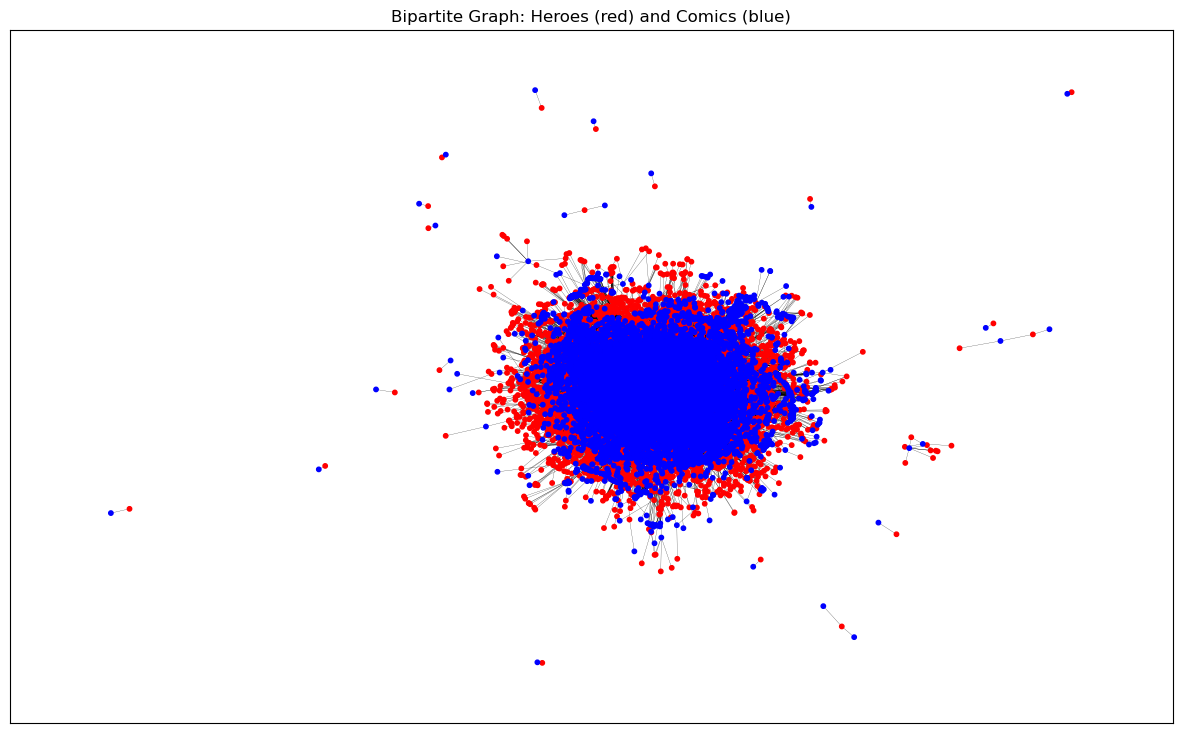

In [30]:
 #Set plot options
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

# Compute layout positions
pos = nx.spring_layout(G, iterations=15, seed=1721)

# Create a color list based on bipartite attribute:
# For example, use "red" for heroes (bipartite==0) and "blue" for comics (bipartite==1)
node_colors = ["red" if data["bipartite"] == 0 else "blue" 
               for node, data in G.nodes(data=True)]

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 9))

# Draw the graph with node_color based on bipartite attribute
nx.draw_networkx(G, pos=pos, ax=ax, node_color=node_colors, **plot_options)

plt.title("Bipartite Graph: Heroes (red) and Comics (blue)")
plt.show()

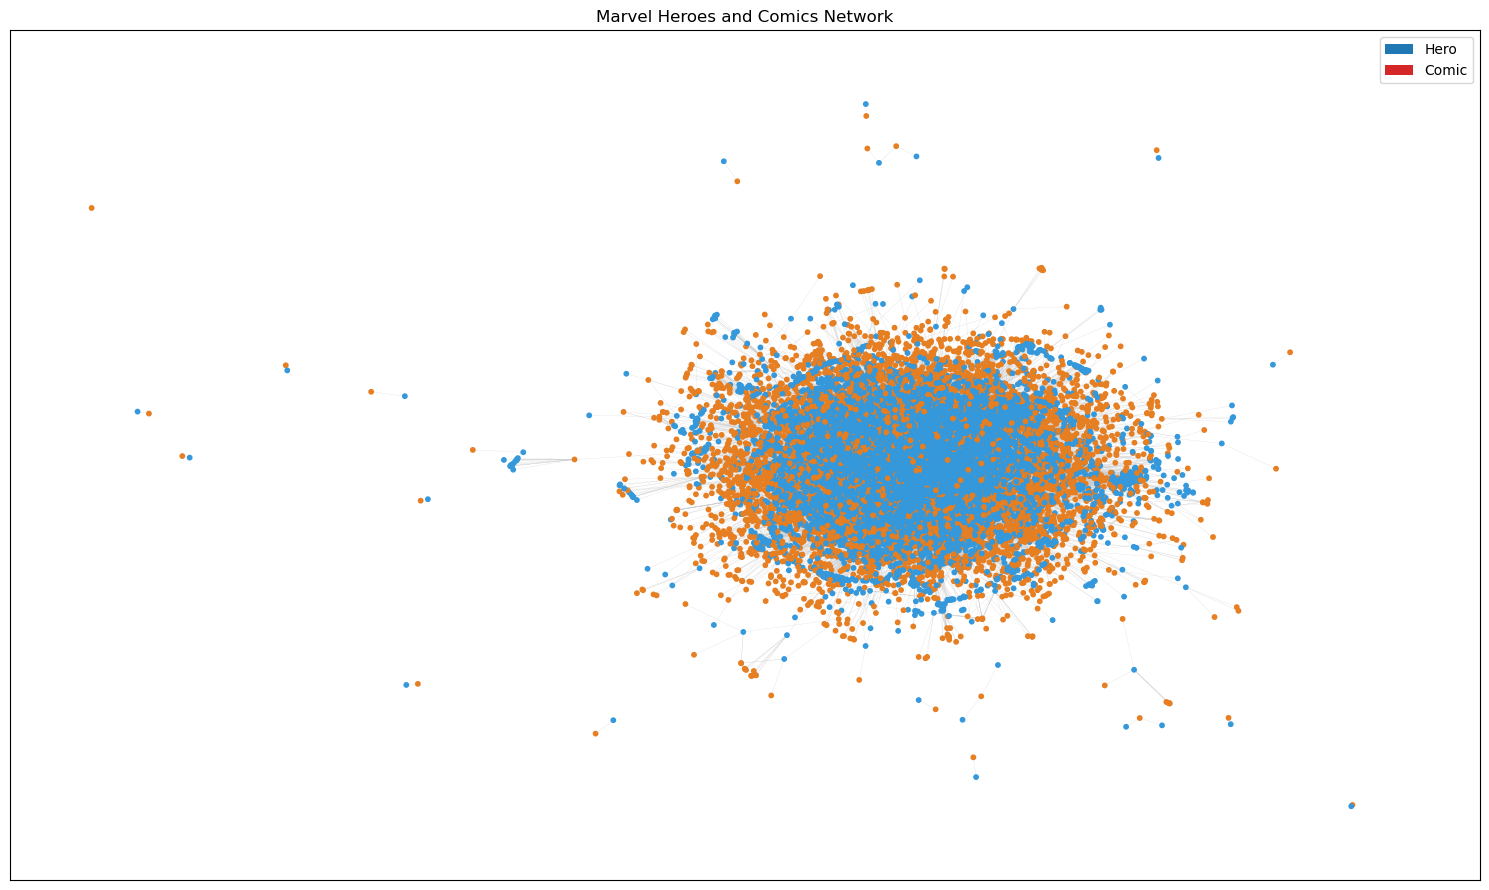

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


# # Option 1: Blue and Red
# node_colors = ['#1f77b4' if G.nodes[node].get('type') == 'hero' else '#d62728' for node in G.nodes()]


# Option 3: Orange and Blue
node_colors = ['#e67e22' if G.nodes[node].get('type')== 'hero' else '#3498db' for node in G.nodes()]

# Set up plot options and draw
plot_options = {
    "node_size": 10, 
    "with_labels": False, 
    "width": 0.15,
    "node_color": node_colors,
    "edge_color": "#CCCCCC"  # Light gray edges
}

pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

# Add legend (update the colors to match your choice)
hero_patch = plt.Circle((0, 0), 0.02, fc='#1f77b4', label='Hero')
comic_patch = plt.Circle((0, 0), 0.02, fc='#d62728', label='Comic')
plt.legend(handles=[hero_patch, comic_patch])

plt.title("Marvel Heroes and Comics Network")
plt.tight_layout()
plt.show()

In [4]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)

# Connect to "test" database as root user.
sys_db = client.db("_system", username=arango_user, password=arango_password)

In [5]:
print(sys_db.collections())

[{'id': '4', 'name': '_statistics', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '7', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '10', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '5', 'name': '_statistics15', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '8', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '11', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '6', 'name': '_statisticsRaw', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '9', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '12', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '14', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '13', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}

In [36]:

# Define the new database name
NEW_DATABASE_NAME = "Marvel"

# Create the database if it does not exist
if not sys_db.has_database(NEW_DATABASE_NAME):
    sys_db.create_database(NEW_DATABASE_NAME)
    print(f"Database '{NEW_DATABASE_NAME}' created successfully!")
else:
    print(f"Database '{NEW_DATABASE_NAME}' already exists.")

Database 'Marvel' created successfully!


In [35]:
# Delete the database
sys_db = client.db('_system', username=arango_user, password=arango_password)
if sys_db.has_database(arango_db):
    sys_db.delete_database(arango_db)
    print(f"Deleted database {arango_db}")
    

Deleted database Marvel


In [5]:
# Initialize the client for ArangoDB.
client = ArangoClient(hosts=arango_host)
db = client.db(arango_db, username=arango_user, password=arango_password)
print(db.collections())

[{'id': '67283', 'name': '_analyzers', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '67286', 'name': '_jobs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '67289', 'name': '_frontend', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '68121', 'name': 'Heroes_Comics_node', 'system': False, 'type': 'document', 'status': 'loaded'}, {'id': '68122', 'name': 'Heroes_Comics_node_to_Heroes_Comics_node', 'system': False, 'type': 'edge', 'status': 'loaded'}, {'id': '67282', 'name': '_graphs', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '67285', 'name': '_queues', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '67288', 'name': '_appbundles', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '67284', 'name': '_aqlfunctions', 'system': True, 'type': 'document', 'status': 'loaded'}, {'id': '67287', 'name': '_apps', 'system': True, 'type': 'document', 'status': 'loaded'}]


In [42]:
# Delete the existing Marvel graph
if db.has_graph('Heroes_Comics'):
    db.delete_graph('Heroes_Comics', drop_collections=True)
    print("Existing Marvel graph deleted")

In [43]:
# Delete collections if they exist
if db.has_collection('Heroes_Comics_node'):
    db.delete_collection('Heroes_Comics_node')
    print("Deleted Heroes_Comics_node collection")


In [45]:
# Delete the graph if it already exists
db.delete_graph("Heroes_Comics", drop_collections=True, ignore_missing=True)

vertex_collection_mapping = {
    0: "Heroes",
    1: "Comics"
}

# Create the ArangoDB graph with separate vertex collections.
G_adb = nxadb.Graph(
    name="Heroes_Comics",
    db=db,
    edge_definitions=[
        {
            'edge_collection': 'hasAppearedIn',
            'from_vertex_collections': ['Heroes'],
            'to_vertex_collections': ['Comics']
        }
    ],
    incoming_graph_data=G,          # Your NetworkX graph from earlier
    write_batch_size=50000,
    overwrite_graph=True,
    vertex_collection_field="bipartite",  # Field to use for choosing the vertex collection
    vertex_collection_mapping=vertex_collection_mapping
)

print(G_adb)

[17:08:12 -0600] [INFO]: Graph 'Heroes_Comics' created.
[2025/02/15 17:08:12 -0600] [594558] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database 'Marvel'


Output()

Output()

[2025/02/15 17:08:17 -0600] [594558] [INFO] - adbnx_adapter: Created ArangoDB 'Heroes_Comics' Graph


Graph named 'Heroes_Comics' with 19090 nodes and 0 edges


In [6]:

G_adb = nxadb.Graph(name="Heroes_Comics", db=db)

print(G_adb)

[18:50:18 -0600] [INFO]: Graph 'Heroes_Comics' exists.
[18:50:18 -0600] [INFO]: Default node type set to 'Heroes_Comics_node'


Graph named 'Heroes_Comics' with 19090 nodes and 96104 edges


### AQL Test

In [48]:
# First, let's check what collections exist
print("Available collections:")
for collection in db.collections():
    print(collection['name'])

# Get the graph to see its collections
graph = db.graph('Heroes_Comics')
print("\nGraph collections:")
print(graph.edge_definitions())

Available collections:
Heroes_Comics_node
_aqlfunctions
_apps
Heroes_Comics_node_to_Heroes_Comics_node
_queues
_appbundles
_graphs
_analyzers
_jobs
_frontend

Graph collections:
[{'edge_collection': 'Heroes_Comics_node_to_Heroes_Comics_node', 'from_vertex_collections': ['Heroes_Comics_node'], 'to_vertex_collections': ['Heroes_Comics_node']}]


In [34]:
# 1. Find all heroes and their comic count
aql_heroes = """
FOR node IN Heroes_Comics_node
    FILTER node.type == 'hero'
    LET comic_count = LENGTH(
        FOR v, e IN 1..1 ANY node Heroes_Comics_node_to_Heroes_Comics_node
        FILTER v.type == 'comic'
        RETURN v
    )
    SORT comic_count DESC
    LIMIT 10
    RETURN {
        hero: node.label,
        comics: comic_count
    }
"""
print("Top 10 Heroes by Comic Appearances:")
cursor = db.aql.execute(aql_heroes)
for hero in cursor:
    print(f"{hero['hero']}: {hero['comics']} comics")


# 2. Find comics with most hero connections
aql_comics = """
FOR node IN Heroes_Comics_node
    FILTER node.type == 'comic'
    LET hero_count = LENGTH(
        FOR v, e IN 1..1 ANY node Heroes_Comics_node_to_Heroes_Comics_node
        FILTER v.type == 'hero'
        RETURN v
    )
    SORT hero_count DESC
    LIMIT 5
    RETURN {
        comic: node.label,
        heroes: hero_count
    }
"""
print("\nTop 5 Comics by Number of Heroes:")
cursor = db.aql.execute(aql_comics)
for comic in cursor:
    print(f"{comic['comic']}: {comic['heroes']} heroes")



# 3. Basic statistics
aql_stats = """
RETURN {
    total_nodes: LENGTH(Heroes_Comics_node),
    heroes: LENGTH(FOR n IN Heroes_Comics_node FILTER n.type == 'hero' RETURN n),
    comics: LENGTH(FOR n IN Heroes_Comics_node FILTER n.type == 'comic' RETURN n),
    edges: LENGTH(Heroes_Comics_node_to_Heroes_Comics_node)
}
"""
print("\nGraph Statistics:")
cursor = db.aql.execute(aql_stats)
for stats in cursor:
    print(f"Total Nodes: {stats['total_nodes']}")
    print(f"Heroes: {stats['heroes']}")
    print(f"Comics: {stats['comics']}")
    print(f"Total Connections: {stats['edges']}")




Top 10 Heroes by Comic Appearances:
CAPTAIN AMERICA: 1334 comics
IRON MAN / TONY STARK: 1150 comics
THING / BENJAMIN J. GR: 963 comics
THOR / DR. DONALD BLAK: 956 comics
HUMAN TORCH / JOHNNY S: 886 comics
MR. FANTASTIC / REED R: 854 comics
HULK / DR. ROBERT BRUC: 835 comics
WOLVERINE / LOGAN: 819 comics
INVISIBLE WOMAN / SUE: 762 comics
SCARLET WITCH / WANDA: 643 comics

Top 5 Comics by Number of Heroes:
COC 1: 110 heroes
IW 3: 90 heroes
IW 1: 89 heroes
H2 279: 86 heroes
IW 4: 80 heroes

Graph Statistics:
Total Nodes: 19091
Heroes: 6439
Comics: 12651
Total Connections: 96104




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Heroes_Comics_node, Heroes_Comics_node_to_Heroes_Comics_node
FOR hero IN Heroes_Comics_node
    FILTER hero.type == "hero"
    LET comicCount = LENGTH(
        FOR comic IN Heroes_Comics_node_to_Heroes_Comics_node
            FILTER comic._from == hero._id
            RETURN comic
    )
    SORT comicCount DESC
    RETURN { hero: hero.label, comicCount }

AQL Result:
[{'hero': 'DAREDEVIL / MATT MURDO', 'comicCount': 569}, {'hero': 'BEAST / HENRY &HANK& P', 'comicCount': 517}, {'hero': 'CYCLOPS / SCOTT SUMMER', 'comicCount': 513}, {'hero': 'CAPTAIN AMERICA', 'comicCount': 509}, {'hero': 'COLOSSUS II / PETER RA', 'comicCount': 443}, {'hero': 'ANGEL / WARREN KENNETH', 'comicCount': 433}, {'hero': 'MARVEL GIRL / JEAN GRE', 'comicCount': 387}, {'hero': 'STORM / ORORO MUNROE S', 'comicCount': 368}, {'hero': 'PROFESSOR X / CHARLES', 'comicCount': 352}, {'hero': 'ANT-MAN / DR. HENRY J.', 'comicCount': 342}]

> Finished chain.


### Agent

In [7]:
arango_graph = ArangoGraph(db)

In [8]:
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_523b9b6e5f', 'finish_reason': 'stop', 'logprobs': None}, id='run-62d4d421-4f4e-42d3-a0e8-91156a393dcd-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [9]:

# @tool
# def text_to_aql_to_text(query: str):
#     """This tool is available to invoke the
#     ArangoGraphQAChain object, which enables you to
#     translate a Natural Language Query into AQL, execute
#     the query, and translate the result back into Natural Language.
#     """

#     llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

#     chain = ArangoGraphQAChain.from_llm(
#     	llm=llm,
#     	graph=arango_graph,
#     	verbose=True,
#         allow_dangerous_requests=True
#     )
    
#     result = chain.invoke(query)

#     return str(result["result"])

In [10]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    # Add system message to guide AQL generation
    system_message = """You are an expert in ArangoDB and AQL query generation.
    When counting connections between heroes and comics:
    1. Use OUTBOUND or INBOUND instead of ANY to ensure consistent direction
    2. Use graph traversal (FOR v, e, p IN 1..1 OUTBOUND) instead of edge collection filtering
    3. Always verify node types in the traversal
    4. Use consistent naming conventions
    
    Example of correct hero-comic counting:
    ```aql
    FOR hero IN Heroes_Comics_node
        FILTER hero.type == 'hero'
        LET comic_count = LENGTH(
            FOR v, e IN 1..1 OUTBOUND hero Heroes_Comics_node_to_Heroes_Comics_node
            FILTER v.type == 'comic'
            RETURN v
        )
        SORT comic_count DESC
        RETURN {
            hero: hero.label,
            comics: comic_count
        }
    ```
    """

    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True,
        system_message=system_message
    )
    
    result = chain.invoke(query)

    return str(result["result"])

In [11]:
import json
# Print schema in a readable format
print("\n=== Graph Schema ===")
print(json.dumps(arango_graph.schema, indent=2))



=== Graph Schema ===
{
  "Graph Schema": [
    {
      "graph_name": "Heroes_Comics",
      "edge_definitions": [
        {
          "edge_collection": "Heroes_Comics_node_to_Heroes_Comics_node",
          "from_vertex_collections": [
            "Heroes_Comics_node"
          ],
          "to_vertex_collections": [
            "Heroes_Comics_node"
          ]
        }
      ]
    }
  ],
  "Collection Schema": [
    {
      "collection_name": "Heroes_Comics_node",
      "collection_type": "document",
      "document_properties": [
        {
          "name": "_key",
          "type": "str"
        },
        {
          "name": "_id",
          "type": "str"
        },
        {
          "name": "_rev",
          "type": "str"
        },
        {
          "name": "bipartite",
          "type": "int"
        },
        {
          "name": "label",
          "type": "str"
        }
      ],
      "example_document": {
        "_key": "0",
        "_id": "Heroes_Comics_node/0",
    

In [12]:
# 5. Define the Text to NetworkX/cuGraph Tool
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text


In [15]:
tools = [text_to_aql_to_text,text_to_nx_algorithm_to_text]

In [16]:
def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [13]:
query_graph("Who are the heroes who appeared in most comics")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Heroes_Comics_node, Heroes_Comics_node_to_Heroes_Comics_node
FOR hero IN Heroes_Comics_node
    LET appearances = (
        FOR edge IN Heroes_Comics_node_to_Heroes_Comics_node
            FILTER edge._from == hero._id
            COLLECT WITH COUNT INTO count
            RETURN count
    )
    SORT appearances[0] DESC
    RETURN { hero: hero.label, appearances: appearances[0] }

AQL Result:
[{'hero': 'SPIDER-MAN / PETER PARKER', 'appearances': 1577}, {'hero': 'CAPTAIN AMERICA', 'appearances': 1334}, {'hero': 'IRON MAN / TONY STARK', 'appearances': 1150}, {'hero': 'THING / BENJAMIN J. GR', 'appearances': 963}, {'hero': 'THOR / DR. DONALD BLAK', 'appearances': 956}, {'hero': 'HUMAN TORCH / JOHNNY S', 'appearances': 886}, {'hero': 'MR. FANTASTIC / REED R', 'appearances': 854}, {'hero': 'HULK / DR. ROBERT BRUC', 'appearances': 835}, {'hero': 'WOLVERINE / LOGAN', 'appearances': 819}, {'hero': 'INVISIBLE WOMAN / SUE', 'appeara

'The heroes who have appeared in the most comics are:\n\n1. Spider-Man (Peter Parker) - 1,577 appearances\n2. Captain America - 1,334 appearances\n3. Iron Man (Tony Stark) - 1,150 appearances\n4. The Thing (Benjamin J. Grimm) - 963 appearances\n5. Thor (Dr. Donald Blake) - 956 appearances\n6. The Human Torch (Johnny Storm) - 886 appearances\n7. Mr. Fantastic (Reed Richards) - 854 appearances\n8. The Hulk (Dr. Robert Bruce Banner) - 835 appearances\n9. Wolverine (Logan) - 819 appearances\n10. The Invisible Woman (Sue Storm) - 762 appearances'

In [19]:
def dummy_query_graph(query):
    # Simulate a query response
    return "Query processed successfully!"

def create_interface():
    with gradio.Blocks(title="Marvel Heroes Graph Explorer") as demo:
        # Header
        gradio.Markdown(
            """
            # Marvel Heroes Graph Explorer
            
            This interface allows you to explore the Marvel Heroes and Comics graph database using natural language queries.
            """
        )
        
        # Main interface
        with gradio.Row():
            with gradio.Column(scale=4):
                query_input = gradio.Textbox(
                    label="Enter your query",
                    placeholder="Example: Show me connections between heroes",
                    lines=3
                )
                with gradio.Row():
                    submit_btn = gradio.Button("Submit", variant="primary")
                    clear_btn = gradio.Button("Clear")
                
            with gradio.Column(scale=6):
                output = gradio.HTML(
                    label="Result"
                )
                
        # Query history
        with gradio.Accordion("Query History", open=False):
            history = gradio.HTML()
        
        # Event handlers
        def process_query(query, history_html):
            # Get text result
            result = dummy_query_graph(query)
            
            # Dummy data for visualization
            sample_data = {
                "nodes": [
                    {"id": 1, "name": "Spider-Man"},
                    {"id": 2, "name": "Iron Man"},
                    {"id": 3, "name": "Captain America"},
                    {"id": 4, "name": "Thor"},
                    {"id": 5, "name": "Black Widow"}
                ],
                "links": [
                    {"source": 1, "target": 2},
                    {"source": 2, "target": 3},
                    {"source": 1, "target": 3},
                    {"source": 4, "target": 2},
                    {"source": 3, "target": 4},
                    {"source": 5, "target": 2},
                    {"source": 5, "target": 3}
                ]
            }
            
            # Generate visualization HTML
            viz_html = create_d3_visualization(sample_data["nodes"], sample_data["links"])
            
            # Combine text result with visualization
            combined_result = f"""
            <div style="margin-bottom: 20px;">
                <p>{result}</p>
            </div>
            {viz_html}
            """
            
            new_history = f"<p><strong>Q:</strong> {query}<br><strong>A:</strong> {result}</p>" + history_html
            return combined_result, new_history
        
        def clear_inputs():
            return "", ""
        
        submit_btn.click(
            process_query,
            inputs=[query_input, history],
            outputs=[output, history]
        )
        
        clear_btn.click(
            clear_inputs,
            inputs=[],
            outputs=[query_input, output]
        )
        
        query_input.submit(
            process_query,
            inputs=[query_input, history],
            outputs=[output, history]
        )
    
    return demo

# Launch the interface
create_interface().launch(share=True)

* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://b6730950ac163c0c5b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Python: create_d3_visualization function called
Python: create_d3_visualization function called
